In [126]:
# Gute Fragestellung für datascience Projekt (Sportify)
# Gibt es einen Zusammenhang zwischen eigenen Musikgeschmack und der Geschmack der anderen?

# Importieren der benötigten Bibliotheken
import sys
import os as os
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook

# Variablen und Funktionsdeklarationen

Um mit spotipy auf die Daten zugreiffen zu können, müssen `CLIENT_ID` und `CLIENT_SECRET` zwingendermassen gesetzt sein. Die Variablen `USERSANGEETHS` und `USERSTIAFEN` notwendig da wir mit der Spotipy methode `user_playlist` arbeiten.

In [127]:
CLIENT_ID = "082b3dd7a97642d49b60a647673caa75"
CLIENT_SECRET = "276e4715f8a14a34a7622c0105a8588c"
USERSANGEETHS = "qme120m1x3bg2wrtw3haiiyrb"
USERSTIAFEN = "stiafen"

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [128]:
# get all playlists of a user
def get_playlists(user):
    playlists = sp.user_playlists(user)
    playlist_ids = []
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            playlist_ids.append(playlist['id'])
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None
    return playlist_ids

In [129]:
playlistsSangeeths = get_playlists(USERSANGEETHS)
playlistsTiafen = get_playlists(USERSTIAFEN)

# get the name of the playlists, will later be used to print all available playlists for a user
def get_playlist_name(user, playlist_id):
    playlist = sp.user_playlist(user, playlist_id)
    return playlist['name'], playlist['id']


In [130]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    df = pd.DataFrame(tracks)
    df = df['track']
    df = df.apply(pd.Series)
    return df


In [131]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks_artists(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [132]:
def get_audio_features(user, tracklist):
    #Dateinamen festlegen, falls vorhanden werden diese Daten ausgewertet statt Abfragen per API zu machen
    audiofeaturesfilename = user+"_audiofeatures.csv"

    if not os.path.isfile(audiofeaturesfilename):
        genres = []
        popularity = []
        features = []

        #Extract Audio Features
        for uri in tracklist['uri']:

            features = features+sp.audio_features(uri)


        #for artist in tracksStiafen['artists']:
        #    dictionary = artist[0]
        #    artistinfo = sp.artist(dictionary['id'])
        #    artistpopularity = artistinfo['popularity']
        #    artistgenres = artistinfo['genres']
        #    popularity.append(artistpopularity)
        #    genres.append(artistgenres)

        #Dataframe generieren
        audioFeatures = pd.DataFrame(features)
        audioFeatures['user'] = user
        #audioFeatures['genre'] = genres
        #audioFeatures['popularity'] = popularity
        #tracklist['artistgenre'] = genres
        #Daten exportieren

        audioFeatures.to_csv(audiofeaturesfilename)
        return audioFeatures

    else:
        audioFeatures = pd.read_csv(audiofeaturesfilename)
        return audioFeatures

Um nun die ID der playlist zu erhalten, in welcher wir unsere Lieblingssongs gespeichert haben nutzen wir die zuvor definierte Funktion `get_playlist_name` welche über das Resultat der Funktion `get_playlists` für den jeweiligen Benutzer läuft.
Um die Übersicht zu behalten haben wir unsere Playlists *Fav Songs "NAME"* genannt

In [133]:
for playlist in playlistsSangeeths:
    print(get_playlist_name(USERSANGEETHS, playlist))

for playlist in playlistsTiafen:
    print(get_playlist_name(USERSTIAFEN, playlist))

('Testo pur🏋🏽', '7o70luarSZS5DHoODMH51U')
('Fav Songs Sangeeths', '2E7GAf1h3F19ezc18w1NpZ')
('Tamil Vibes', '64Lq6W07GIOs087K88iOzT')
('Arabic  Vibes', '1Rr83zHLDULxQDbC9taydm')
('Albanien Vibes', '6jyy1HUool6rj0xWLVsAPC')
('UK DRILL ', '5ycwKESGY1Z71ftYWmTVJs')
('Baba Vibes', '67a5HCEjwm4aXvjPVoxoAX')
('Fav Songs Stiafen', '0ekbyk9EKkCf4MBjrQoM2D')
('Favorite Songs', '4DeCJm3aeeb0TTdthf8MGY')
('Caterpillar (feat. Eminem & King Green)', '1JKSl9B6hJNCGFs9FdOq8I')
('Meine Playlist Nr.\xa034', '3uBDJVShkGJKFxPNnjC7IL')
('Dein Mixtape\xa06 - ZUSAMMENGESTELLT FÜR STIAFEN:21.06.19', '48I13UCIzloZpyRE23zwIa')
('Mixtape 3', '2jnqcj5CxaBLHjzVafdmce')
('Oldschool', '4RjDNPzba04zlAan0a4bTE')


# Daten sammeln
Nun da wir die Playlist ID haben können wir die Tracks aus unseren Fav Songs Playlists auslesen und mittels unserer Funktion die audio Features extrahieren.

In [134]:
#Variablen für Playlists Sangeeths und Stiafen
favoritplaylistSangeeths = "2E7GAf1h3F19ezc18w1NpZ"
favoritplaylistStiafen = "0ekbyk9EKkCf4MBjrQoM2D"


# Für Beide User wird eine Dataframe mit allen Tracks erstellt
tracksSangeeths = get_playlist_tracks(USERSANGEETHS, favoritplaylistSangeeths)
tracksStiafen = get_playlist_tracks(USERSTIAFEN, favoritplaylistStiafen)

In [135]:
audioFeaturesStiafen = get_audio_features("Stiafen", tracksStiafen)
audioFeaturesSangeeths = get_audio_features("Sangeeths", tracksSangeeths)
#Um über das Gesamtbild der Daten eine aussage machen zu können nehmen wir beide Dataframes in eines
audioFeaturesTotal = audioFeaturesStiafen.append(audioFeaturesSangeeths)

C:\Users\Startklar\AppData\Local\Temp\ipykernel_7456\1617616210.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audioFeaturesTotal = audioFeaturesStiafen.append(audioFeaturesSangeeths)


# Data Preprocessing
Nun da wir alle Daten gesammelt haben ist es an der Zeit uns einen Überblick zu erschaffen.

In [136]:
audioFeaturesTotal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1450 non-null   int64  
 1   danceability      1450 non-null   float64
 2   energy            1450 non-null   float64
 3   key               1450 non-null   int64  
 4   loudness          1450 non-null   float64
 5   mode              1450 non-null   int64  
 6   speechiness       1450 non-null   float64
 7   acousticness      1450 non-null   float64
 8   instrumentalness  1450 non-null   float64
 9   liveness          1450 non-null   float64
 10  valence           1450 non-null   float64
 11  tempo             1450 non-null   float64
 12  type              1450 non-null   object 
 13  id                1450 non-null   object 
 14  uri               1450 non-null   object 
 15  track_href        1450 non-null   object 
 16  analysis_url      1450 non-null   object 
 

In [137]:
audioFeaturesTotal.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,user
0,0,0.0614,0.05800,2,-20.976,1,0.0418,0.918,0.915,0.1490,0.0329,58.193,audio_features,3ddAtoSripaeASJeovlIsg,spotify:track:3ddAtoSripaeASJeovlIsg,https://api.spotify.com/v1/tracks/3ddAtoSripae...,https://api.spotify.com/v1/audio-analysis/3ddA...,1463704,4,Stiafen
1,1,0.2990,0.00626,9,-30.923,1,0.0478,0.994,0.901,0.0823,0.0634,69.043,audio_features,1Oo7XEqkrwifJn17aA0ocF,spotify:track:1Oo7XEqkrwifJn17aA0ocF,https://api.spotify.com/v1/tracks/1Oo7XEqkrwif...,https://api.spotify.com/v1/audio-analysis/1Oo7...,378733,4,Stiafen
2,2,0.0877,0.07630,9,-23.986,1,0.0429,0.645,0.897,0.3530,0.0509,78.535,audio_features,3o9br9LskOEbwc5irxfHqR,spotify:track:3o9br9LskOEbwc5irxfHqR,https://api.spotify.com/v1/tracks/3o9br9LskOEb...,https://api.spotify.com/v1/audio-analysis/3o9b...,295219,4,Stiafen
3,3,0.1760,0.05340,10,-27.626,1,0.0406,0.970,0.915,0.2900,0.0332,71.673,audio_features,5TtmI9sfXw4VXco0PE21mV,spotify:track:5TtmI9sfXw4VXco0PE21mV,https://api.spotify.com/v1/tracks/5TtmI9sfXw4V...,https://api.spotify.com/v1/audio-analysis/5Ttm...,132120,5,Stiafen
4,4,0.4280,0.00300,0,-31.005,1,0.0709,0.995,0.924,0.0889,0.0934,69.108,audio_features,6aD8MeXrjHNz7YgrTLHhyA,spotify:track:6aD8MeXrjHNz7YgrTLHhyA,https://api.spotify.com/v1/tracks/6aD8MeXrjHNz...,https://api.spotify.com/v1/audio-analysis/6aD8...,407947,3,Stiafen


Folgende Spalten sind für uns nicht weiter von Bedeutung

In [138]:
audioFeaturesTotal.drop("Unnamed: 0", axis=1, inplace=True)
audioFeaturesTotal.drop("track_href", axis=1, inplace=True)
audioFeaturesTotal.drop("analysis_url", axis=1, inplace=True)
audioFeaturesTotal.drop("id", axis=1, inplace=True)
audioFeaturesTotal.drop("uri", axis=1, inplace=True)
audioFeaturesTotal.drop("type", axis=1, inplace=True)

Nun sieht der Datensatz schon ein wenig übersichtlicher aus.

In [139]:
audioFeaturesTotal

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user
0,0.0614,0.05800,2,-20.976,1,0.0418,0.9180,0.91500,0.1490,0.0329,58.193,1463704,4,Stiafen
1,0.2990,0.00626,9,-30.923,1,0.0478,0.9940,0.90100,0.0823,0.0634,69.043,378733,4,Stiafen
2,0.0877,0.07630,9,-23.986,1,0.0429,0.6450,0.89700,0.3530,0.0509,78.535,295219,4,Stiafen
3,0.1760,0.05340,10,-27.626,1,0.0406,0.9700,0.91500,0.2900,0.0332,71.673,132120,5,Stiafen
4,0.4280,0.00300,0,-31.005,1,0.0709,0.9950,0.92400,0.0889,0.0934,69.108,407947,3,Stiafen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.5940,0.80300,6,-6.269,1,0.2650,0.0449,0.00000,0.2370,0.2580,84.781,145322,4,Sangeeths
795,0.6020,0.52600,11,-8.748,1,0.4010,0.1470,0.00000,0.0874,0.5120,72.661,134480,3,Sangeeths
796,0.7350,0.61500,4,-6.463,0,0.0670,0.0281,0.00444,0.0517,0.4060,97.912,113878,4,Sangeeths
797,0.5690,0.54600,9,-8.306,0,0.4510,0.3380,0.00000,0.0507,0.6340,96.796,196000,4,Sangeeths


Wie wir sehen sind keine Nullwerte vorhanden, welche wir noch entfernen müssten.

In [140]:
audioFeaturesTotal.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
user                0
dtype: int64

Was nun noch fehlt sind Countplots um zu überprüfen wie die Daten Verteilt sind. Hier ist vorallem wichtig das wir von beiden Personen (also Sangeeth und Stiafen) etwa gleich viele Daten haben.
Wie man sieht ist es nicht genau gleich, aber noch verkraftbar.

<AxesSubplot:xlabel='user', ylabel='count'>

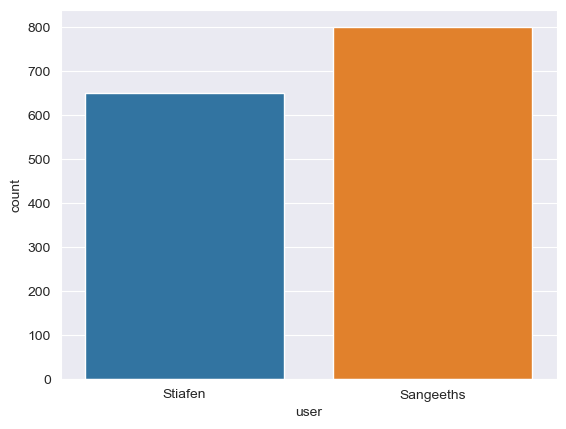

In [141]:
sns.countplot(x =audioFeaturesTotal['user'])

Als letztes werden wir noch die Spalte "User" dazu verwenden um die Daten zu labeln. Das mach wir mittels des LabelEncoders.


In [142]:
labelencoder = LabelEncoder()
audioFeaturesTotal['user'] = labelencoder.fit_transform(audioFeaturesTotal['user'])
audioFeaturesTotal

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user
0,0.0614,0.05800,2,-20.976,1,0.0418,0.9180,0.91500,0.1490,0.0329,58.193,1463704,4,1
1,0.2990,0.00626,9,-30.923,1,0.0478,0.9940,0.90100,0.0823,0.0634,69.043,378733,4,1
2,0.0877,0.07630,9,-23.986,1,0.0429,0.6450,0.89700,0.3530,0.0509,78.535,295219,4,1
3,0.1760,0.05340,10,-27.626,1,0.0406,0.9700,0.91500,0.2900,0.0332,71.673,132120,5,1
4,0.4280,0.00300,0,-31.005,1,0.0709,0.9950,0.92400,0.0889,0.0934,69.108,407947,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.5940,0.80300,6,-6.269,1,0.2650,0.0449,0.00000,0.2370,0.2580,84.781,145322,4,0
795,0.6020,0.52600,11,-8.748,1,0.4010,0.1470,0.00000,0.0874,0.5120,72.661,134480,3,0
796,0.7350,0.61500,4,-6.463,0,0.0670,0.0281,0.00444,0.0517,0.4060,97.912,113878,4,0
797,0.5690,0.54600,9,-8.306,0,0.4510,0.3380,0.00000,0.0507,0.6340,96.796,196000,4,0


# Datenvisualisierungen
Da wir mit K-Means arbeiten wollen, suchen wir bei der Visualisierung mittels Scatterplots nach möglichen Clustern.

In [143]:
#Beginn Visualisierungen
#Dataframe um mögliche Cluster zu finden
allAudioFeatures = audioFeaturesTotal

Die Untenstehende Grafik hat unserer Meinung nach die deutlichste Clusterbildung aufgezeigt, weswegen wir uns für diese Werte

<AxesSubplot:xlabel='energy', ylabel='danceability'>

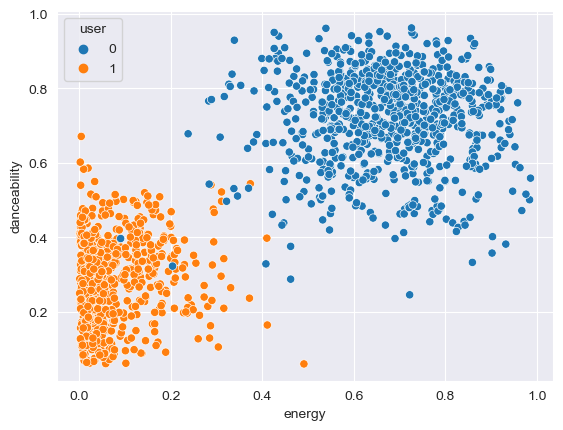

In [144]:
sns.scatterplot(data=allAudioFeatures, x="energy", y="danceability", hue="user")

<AxesSubplot:xlabel='tempo', ylabel='loudness'>

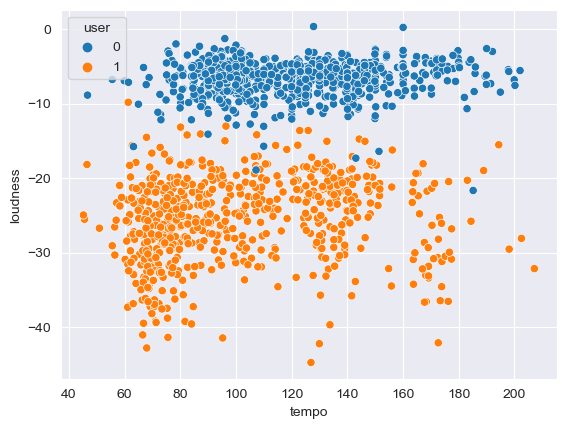

In [145]:
sns.scatterplot(data=allAudioFeatures, x="tempo", y="loudness", hue="user")

<AxesSubplot:xlabel='liveness', ylabel='instrumentalness'>

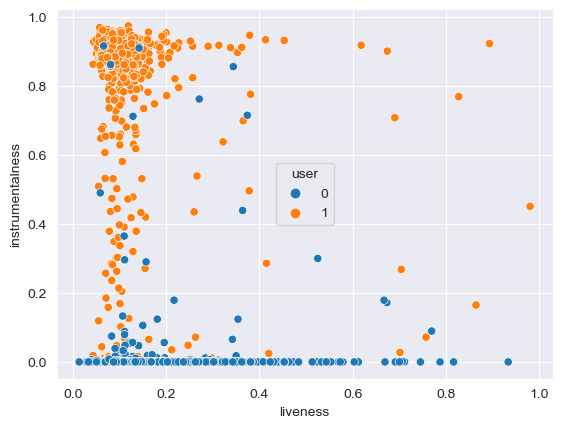

In [146]:
sns.scatterplot(data=allAudioFeatures, x="liveness", y="instrumentalness", hue="user")

<AxesSubplot:xlabel='energy', ylabel='loudness'>

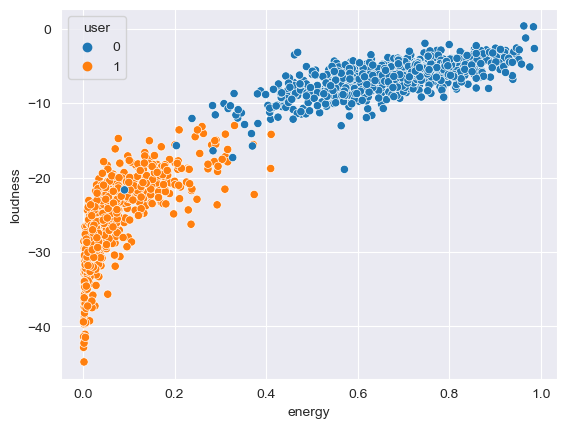

In [147]:
sns.scatterplot(data=allAudioFeatures, x="energy", y="loudness", hue="user")

<AxesSubplot:xlabel='tempo', ylabel='danceability'>

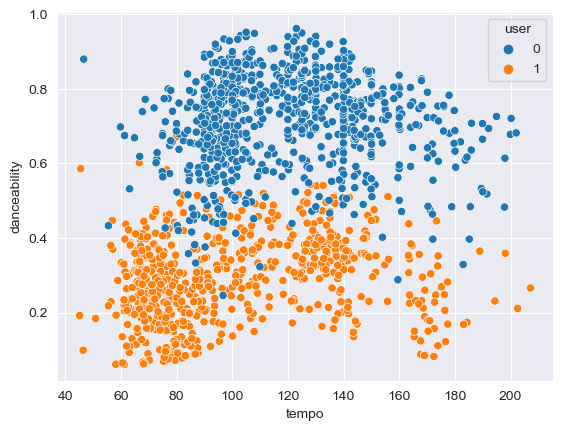

In [148]:
sns.scatterplot(data=allAudioFeatures, x="tempo", y="danceability", hue="user")

<AxesSubplot:xlabel='liveness', ylabel='loudness'>

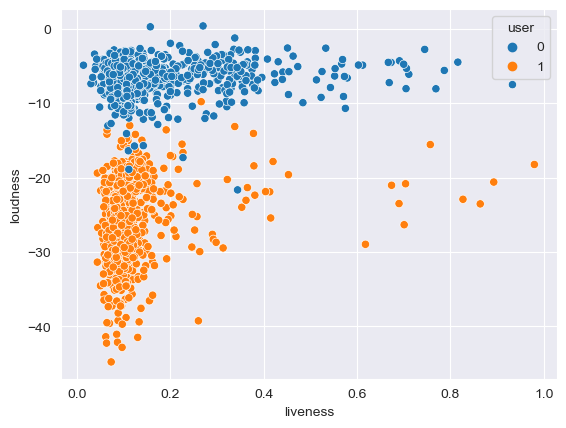

In [149]:
sns.scatterplot(data=allAudioFeatures, x="liveness", y="loudness", hue="user")

<AxesSubplot:xlabel='loudness', ylabel='danceability'>

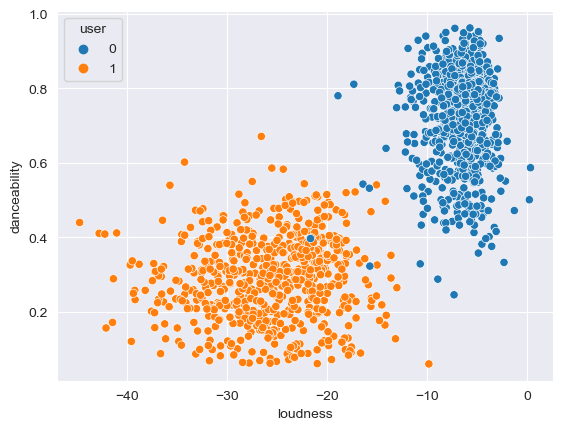

In [150]:
sns.scatterplot(data=allAudioFeatures, x="loudness", y="danceability", hue="user")

C:\Users\Startklar\AppData\Local\Temp\ipykernel_7456\2014212249.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(K):


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Startklar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


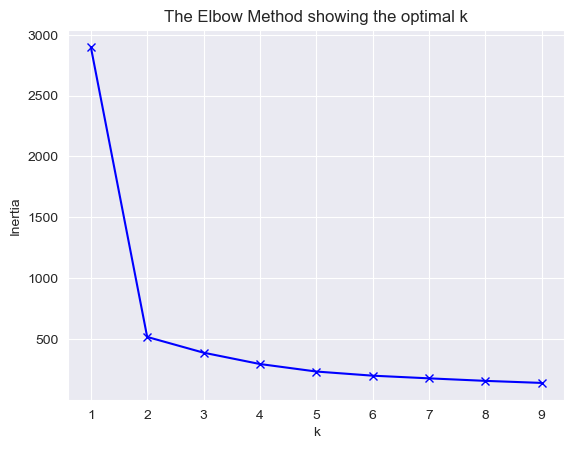

In [151]:



X = allAudioFeatures[['energy','danceability']]

scaler =  StandardScaler()
X_scaled = scaler.fit_transform(X)
inertias = []
K = range(1,10)
for k in tqdm_notebook(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    inertias.append(kmeanModel.inertia_)
    
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')

plt.plot(K, inertias, 'bx-')

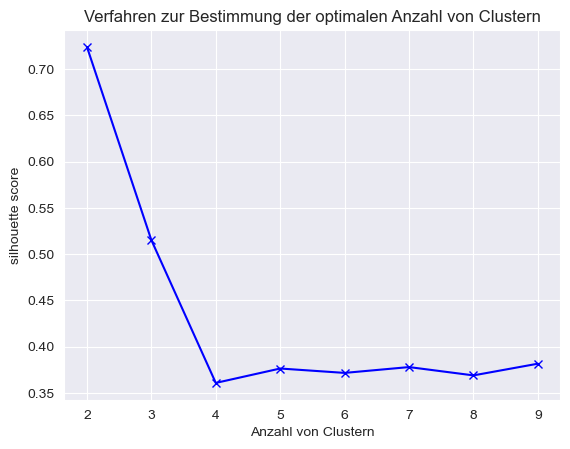

In [152]:

# Merkmale aus der Tabelle auswählen
X = allAudioFeatures[['energy','danceability']].values

# Liste der Anzahl von Clustern erstellen
k_values = range(2, 10)

# Leere Liste für silhouette scores erstellen
scores = []

# Schleife über die Anzahl von Clustern
for k in k_values:
  # K-Means-Modell erstellen
  model = KMeans(n_clusters=k)
  # Modell an die Daten anpassen
  model.fit(X)
  # silhouette score für das Modell berechnen
  score = silhouette_score(X, model.labels_)
  scores.append(score)

# Plot der silhouette scores gegenüber der Anzahl von Clustern erstellen
plt.plot(k_values, scores, 'bx-')
plt.xlabel('Anzahl von Clustern')
plt.ylabel('silhouette score')
plt.title('Verfahren zur Bestimmung der optimalen Anzahl von Clustern')
plt.show()

<AxesSubplot:xlabel='energy', ylabel='danceability'>

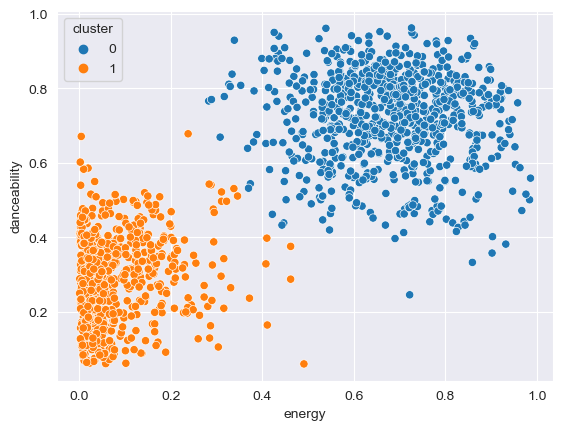

In [153]:


# take the highest value of the silhouette score
kmeans = KMeans(n_clusters=2)
kmeans.fit(allAudioFeatures[['energy', 'danceability']])
allAudioFeatures['cluster'] = kmeans.labels_

sns.scatterplot(data=allAudioFeatures, x="energy", y="danceability", hue="cluster")